In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay
)
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")


✓ All libraries imported successfully


In [11]:
# Update this path to your Dataset.csv location
df = pd.read_csv(r'D:\SCiqus\Dataset.csv')  # e.g. r'D:\SCiqus\Dataset.csv'

print("=" * 80)
print("DATASET LOADING & EXPLORATION")
print("=" * 80)
print(f"\n1. Dataset Shape: {df.shape}")
print(f"   Rows: {df.shape[0]}, Columns: {df.shape[1]}")

print("\n2. First 5 rows of the dataset:")
print(df.head())

print("\n3. Data Types:")
print(df.dtypes)

print("\n4. Missing Values:")
missing = df.isnull().sum()
print(missing)
if missing.sum() == 0:
    print("   ✓ No missing values found - Dataset is complete!")

print("\n5. Dataset Info:")
print(df.info())

print("\n6. Statistical Summary:")
print(df.describe())


DATASET LOADING & EXPLORATION

1. Dataset Shape: (10000, 10)
   Rows: 10000, Columns: 10

2. First 5 rows of the dataset:
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0            


TARGET VARIABLE ANALYSIS - CLASS IMBALANCE

Target Distribution:
Target
0    9661
1     339
Name: count, dtype: int64

Class Proportions (%):
Target
0    96.61
1     3.39
Name: proportion, dtype: float64

Imbalance Ratio:
   No Failure : Failure = 1 : 0.0351
   This is a 28.5x imbalanced dataset
   ⚠️  We have far more No Failure than Failure
   ✓ We will handle this using class_weight='balanced'


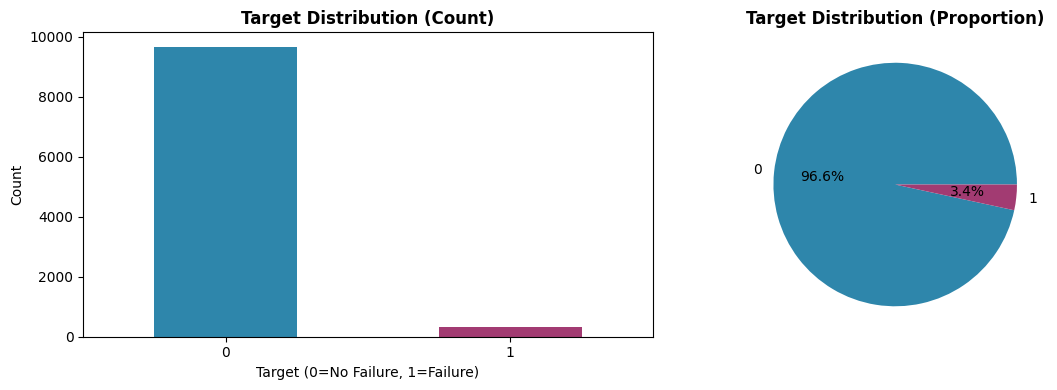

In [13]:
print("\n" + "=" * 80)
print("TARGET VARIABLE ANALYSIS - CLASS IMBALANCE")
print("=" * 80)

print("\nTarget Distribution:")
target_counts = df['Target'].value_counts()
print(target_counts)

print("\nClass Proportions (%):")
print(df['Target'].value_counts(normalize=True) * 100)

print("\nImbalance Ratio:")
imbalance_ratio = target_counts[0] / target_counts[1]
print(f"   No Failure : Failure = 1 : {1/imbalance_ratio:.4f}")
print(f"   This is a {imbalance_ratio:.1f}x imbalanced dataset")
print("   ⚠️  We have far more No Failure than Failure")
print("   ✓ We will handle this using class_weight='balanced'")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df['Target'].value_counts().plot(kind='bar', color=['#2E86AB', '#A23B72'])
plt.title('Target Distribution (Count)', fontsize=12, fontweight='bold')
plt.xlabel('Target (0=No Failure, 1=Failure)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df['Target'].value_counts(normalize=True).plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['#2E86AB', '#A23B72']
)
plt.title('Target Distribution (Proportion)', fontsize=12, fontweight='bold')
plt.ylabel('')

plt.tight_layout()
plt.show()



FEATURE ANALYSIS

1. Categorical Feature - Type Distribution:
Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

2. Numeric Features Analysis:

   Air temperature [K]:
      Min: 295.30, Max: 304.50
      Mean: 300.00, Std: 2.00

   Process temperature [K]:
      Min: 305.70, Max: 313.80
      Mean: 310.01, Std: 1.48

   Rotational speed [rpm]:
      Min: 1168.00, Max: 2886.00
      Mean: 1538.78, Std: 179.28

   Torque [Nm]:
      Min: 3.80, Max: 76.60
      Mean: 39.99, Std: 9.97

   Tool wear [min]:
      Min: 0.00, Max: 253.00
      Mean: 107.95, Std: 63.65

3. Failure Type Distribution:
Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64


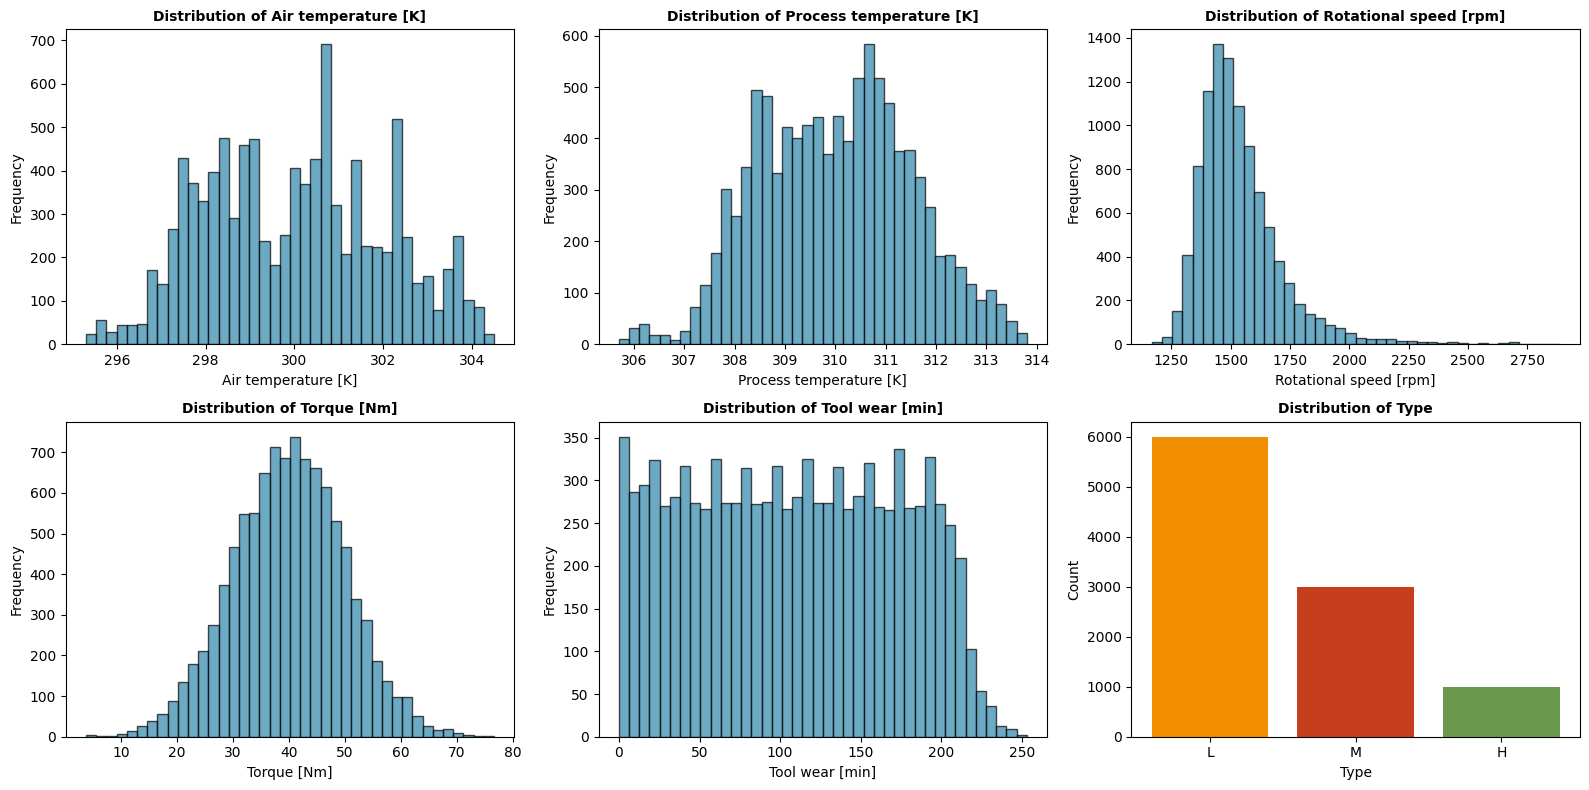

In [15]:
print("\n" + "=" * 80)
print("FEATURE ANALYSIS")
print("=" * 80)

print("\n1. Categorical Feature - Type Distribution:")
print(df['Type'].value_counts())

print("\n2. Numeric Features Analysis:")
numeric_features = [
    'Air temperature [K]', 'Process temperature [K]',
    'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'
]
for col in numeric_features:
    print(f"\n   {col}:")
    print(f"      Min: {df[col].min():.2f}, Max: {df[col].max():.2f}")
    print(f"      Mean: {df[col].mean():.2f}, Std: {df[col].std():.2f}")

print("\n3. Failure Type Distribution:")
print(df['Failure Type'].value_counts())

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.ravel()

for idx, col in enumerate(numeric_features):
    axes[idx].hist(df[col], bins=40, color='#2E86AB',
                   edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

type_counts = df['Type'].value_counts()
axes[5].bar(type_counts.index, type_counts.values,
            color=['#F18F01', '#C73E1D', '#6A994E'])
axes[5].set_title('Distribution of Type', fontsize=10, fontweight='bold')
axes[5].set_xlabel('Type')
axes[5].set_ylabel('Count')

plt.tight_layout()
plt.show()



CORRELATION ANALYSIS

Feature Correlation with Target:
Target                     1.000000
Torque [Nm]                0.191321
Tool wear [min]            0.105448
Air temperature [K]        0.082556
Process temperature [K]    0.035946
Rotational speed [rpm]    -0.044188
Name: Target, dtype: float64


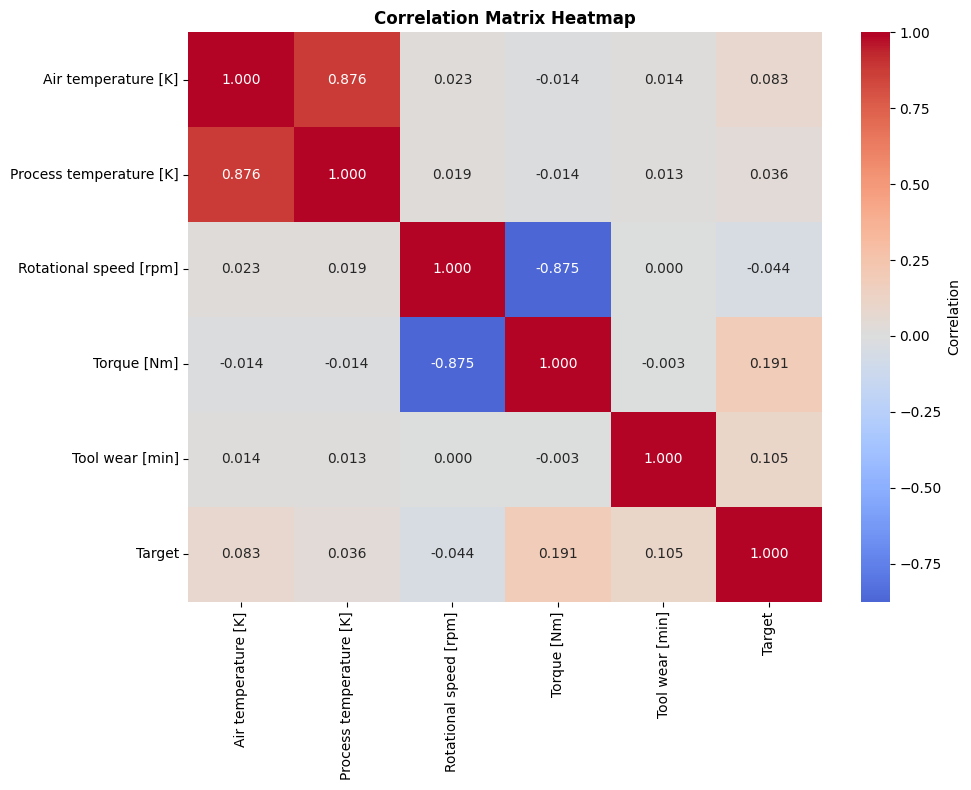


✓ Observations:
   - Tool wear [min] correlation with Target: 0.105
   - Rotational speed [rpm] correlation with Target: -0.044
   - Temperatures have low correlation with Target


In [17]:
print("\n" + "=" * 80)
print("CORRELATION ANALYSIS")
print("=" * 80)

numeric_df = df[[
    'Air temperature [K]', 'Process temperature [K]',
    'Rotational speed [rpm]', 'Torque [Nm]',
    'Tool wear [min]', 'Target'
]]
correlation_matrix = numeric_df.corr()

print("\nFeature Correlation with Target:")
target_corr = correlation_matrix['Target'].sort_values(ascending=False)
print(target_corr)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',
            center=0, fmt='.3f', cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix Heatmap', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Observations:")
print(f"   - Tool wear [min] correlation with Target: {target_corr['Tool wear [min]']:.3f}")
print(f"   - Rotational speed [rpm] correlation with Target: {target_corr['Rotational speed [rpm]']:.3f}")
print("   - Temperatures have low correlation with Target")


In [19]:
print("\n" + "=" * 80)
print("DATA PREPROCESSING - FEATURE ENGINEERING")
print("=" * 80)

print("\n1. Dropping Irrelevant Columns:")
print("   - UDI: row index, not predictive")
print("   - Product ID: identifier, not a feature")
print("   - Failure Type: text description of target (data leakage)")

df_processed = df.drop(['UDI', 'Product ID', 'Failure Type'], axis=1)
print(f"   ✓ Dropped 3 columns. New shape: {df_processed.shape}")

print("\n2. Encoding Categorical Feature (Type):")
print(f"   Original unique values: {df_processed['Type'].unique()}")
label_encoder = LabelEncoder()
df_processed['Type_encoded'] = label_encoder.fit_transform(df_processed['Type'])
print(f"   Mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")
df_processed = df_processed.drop('Type', axis=1)
print("   ✓ Type column encoded successfully")

print("\n3. Final Dataset After Preprocessing:")
print(f"   Shape: {df_processed.shape}")
print(f"   Columns: {list(df_processed.columns)}")
print("   ✓ Dataset is ready for modeling!")

print("\nProcessed Dataset (first 5 rows):")
print(df_processed.head())



DATA PREPROCESSING - FEATURE ENGINEERING

1. Dropping Irrelevant Columns:
   - UDI: row index, not predictive
   - Product ID: identifier, not a feature
   - Failure Type: text description of target (data leakage)
   ✓ Dropped 3 columns. New shape: (10000, 7)

2. Encoding Categorical Feature (Type):
   Original unique values: ['M' 'L' 'H']
   Mapping: {'H': 0, 'L': 1, 'M': 2}
   ✓ Type column encoded successfully

3. Final Dataset After Preprocessing:
   Shape: (10000, 7)
   Columns: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target', 'Type_encoded']
   ✓ Dataset is ready for modeling!

Processed Dataset (first 5 rows):
   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3 

In [21]:
print("\n" + "=" * 80)
print("SEPARATING FEATURES AND TARGET")
print("=" * 80)

X = df_processed.drop('Target', axis=1)
y = df_processed['Target']

print("\nFeatures (X):")
print(f"   Shape: {X.shape}")
print(f"   Columns: {list(X.columns)}")

print("\nTarget (y):")
print(f"   Shape: {y.shape}")
print(f"   Value counts:\n{y.value_counts()}")



SEPARATING FEATURES AND TARGET

Features (X):
   Shape: (10000, 6)
   Columns: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Type_encoded']

Target (y):
   Shape: (10000,)
   Value counts:
Target
0    9661
1     339
Name: count, dtype: int64


In [23]:
print("\n" + "=" * 80)
print("FEATURE SCALING - STANDARDIZATION")
print("=" * 80)

print("\nScaling Features using StandardScaler:")
print("   Method: Standardization (z-score)")
print("   Formula: z = (x - mean) / std")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("\nBefore Scaling (sample statistics):")
print(X.describe().round(2))

print("\nAfter Scaling (sample statistics):")
print(X_scaled.describe().round(2))

print("\n✓ Features successfully scaled!")



FEATURE SCALING - STANDARDIZATION

Scaling Features using StandardScaler:
   Method: Standardization (z-score)
   Formula: z = (x - mean) / std

Before Scaling (sample statistics):
       Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
count              10000.0                 10000.00                10000.00   
mean                 300.0                   310.01                 1538.78   
std                    2.0                     1.48                  179.28   
min                  295.3                   305.70                 1168.00   
25%                  298.3                   308.80                 1423.00   
50%                  300.1                   310.10                 1503.00   
75%                  301.5                   311.10                 1612.00   
max                  304.5                   313.80                 2886.00   

       Torque [Nm]  Tool wear [min]  Type_encoded  
count     10000.00         10000.00       10000.0  
me

In [25]:
print("\n" + "=" * 80)
print("TRAIN-TEST SPLIT WITH STRATIFICATION")
print("=" * 80)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nSplit Details:")
print(f"   Total samples: {len(X_scaled)}")
print(f"   Training set: {len(X_train)} ({len(X_train)/len(X_scaled)*100:.1f}%)")
print(f"   Test set: {len(X_test)} ({len(X_test)/len(X_scaled)*100:.1f}%)")

print("\nClass Distribution in Training Set:")
print(y_train.value_counts())
print("\nClass Distribution in Test Set:")
print(y_test.value_counts())

print("\n✓ Stratification successful!")



TRAIN-TEST SPLIT WITH STRATIFICATION

Split Details:
   Total samples: 10000
   Training set: 8000 (80.0%)
   Test set: 2000 (20.0%)

Class Distribution in Training Set:
Target
0    7729
1     271
Name: count, dtype: int64

Class Distribution in Test Set:
Target
0    1932
1      68
Name: count, dtype: int64

✓ Stratification successful!


In [27]:
print("\n" + "=" * 80)
print("MODEL 1: RANDOM FOREST CLASSIFIER")
print("=" * 80)

print("""
WHY RANDOM FOREST?
1. Handles non-linear relationships and interactions
2. Handles class imbalance with class_weight='balanced'
3. Provides feature importance
4. Robust to outliers
5. Works well on tabular data
""")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

print("\n1. Training Random Forest...")
rf_model.fit(X_train, y_train)
print("   ✓ Training completed")

rf_train_pred = rf_model.predict(X_train)
rf_train_proba = rf_model.predict_proba(X_train)[:, 1]

print("\n2. Random Forest – Training Performance:")
print(f"   Accuracy:  {accuracy_score(y_train, rf_train_pred):.4f}")
print(f"   Precision: {precision_score(y_train, rf_train_pred, zero_division=0):.4f}")
print(f"   Recall:    {recall_score(y_train, rf_train_pred, zero_division=0):.4f}")
print(f"   F1-Score:  {f1_score(y_train, rf_train_pred, zero_division=0):.4f}")
print(f"   ROC-AUC:   {roc_auc_score(y_train, rf_train_proba):.4f}")



MODEL 1: RANDOM FOREST CLASSIFIER

WHY RANDOM FOREST?
1. Handles non-linear relationships and interactions
2. Handles class imbalance with class_weight='balanced'
3. Provides feature importance
4. Robust to outliers
5. Works well on tabular data


1. Training Random Forest...
   ✓ Training completed

2. Random Forest – Training Performance:
   Accuracy:  0.9909
   Precision: 0.7878
   Recall:    1.0000
   F1-Score:  0.8813
   ROC-AUC:   0.9994


In [29]:
print("\n" + "=" * 80)
print("MODEL 2: LOGISTIC REGRESSION")
print("=" * 80)

print("""
WHY LOGISTIC REGRESSION?
1. Simple and interpretable
2. Fast baseline
3. Produces probabilities (good for ensemble)
4. Works well with scaled features
5. Handles imbalance with class_weight='balanced'
""")

lr_model = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

print("\n1. Training Logistic Regression...")
lr_model.fit(X_train, y_train)
print("   ✓ Training completed")

lr_train_pred = lr_model.predict(X_train)
lr_train_proba = lr_model.predict_proba(X_train)[:, 1]

print("\n2. Logistic Regression – Training Performance:")
print(f"   Accuracy:  {accuracy_score(y_train, lr_train_pred):.4f}")
print(f"   Precision: {precision_score(y_train, lr_train_pred, zero_division=0):.4f}")
print(f"   Recall:    {recall_score(y_train, lr_train_pred, zero_division=0):.4f}")
print(f"   F1-Score:  {f1_score(y_train, lr_train_pred, zero_division=0):.4f}")
print(f"   ROC-AUC:   {roc_auc_score(y_train, lr_train_proba):.4f}")

print("\n3. Logistic Regression – Coefficients:")
coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', ascending=False)
print(coeff_df.to_string(index=False))



MODEL 2: LOGISTIC REGRESSION

WHY LOGISTIC REGRESSION?
1. Simple and interpretable
2. Fast baseline
3. Produces probabilities (good for ensemble)
4. Works well with scaled features
5. Handles imbalance with class_weight='balanced'


1. Training Logistic Regression...
   ✓ Training completed

2. Logistic Regression – Training Performance:
   Accuracy:  0.8201
   Precision: 0.1377
   Recall:    0.8192
   F1-Score:  0.2358
   ROC-AUC:   0.8997

3. Logistic Regression – Coefficients:
                Feature  Coefficient
            Torque [Nm]     2.408780
    Air temperature [K]     1.759135
 Rotational speed [rpm]     1.722059
        Tool wear [min]     0.867478
           Type_encoded    -0.101799
Process temperature [K]    -1.205433


In [33]:
print("\n" + "=" * 80)
print("MODEL 3: SOFT VOTING ENSEMBLE (RF + LR)")
print("=" * 80)

print("""
Soft-voting ensemble:
- Combines Random Forest (non-linear) and Logistic Regression (linear)
- Uses averaged predicted probabilities (voting='soft')
- Aims to improve robustness and F1-score on imbalanced data
""")

voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lr', lr_model)
    ],
    voting='soft',
    n_jobs=-1
)

# IMPORTANT: fit the VotingClassifier
print("\nFitting soft voting ensemble on training data...")
voting_model.fit(X_train, y_train)

print("\nUsing soft voting ensemble for predictions on training set.")

voting_train_pred = voting_model.predict(X_train)
voting_train_proba = voting_model.predict_proba(X_train)[:, 1]

print("\nEnsemble – Training Performance:")
print(f"   Accuracy:  {accuracy_score(y_train, voting_train_pred):.4f}")
print(f"   Precision: {precision_score(y_train, voting_train_pred, zero_division=0):.4f}")
print(f"   Recall:    {recall_score(y_train, voting_train_pred, zero_division=0):.4f}")
print(f"   F1-Score:  {f1_score(y_train, voting_train_pred, zero_division=0):.4f}")
print(f"   ROC-AUC:   {roc_auc_score(y_train, voting_train_proba):.4f}")



MODEL 3: SOFT VOTING ENSEMBLE (RF + LR)

Soft-voting ensemble:
- Combines Random Forest (non-linear) and Logistic Regression (linear)
- Uses averaged predicted probabilities (voting='soft')
- Aims to improve robustness and F1-score on imbalanced data


Fitting soft voting ensemble on training data...

Using soft voting ensemble for predictions on training set.

Ensemble – Training Performance:
   Accuracy:  0.9683
   Precision: 0.5178
   Recall:    0.9114
   F1-Score:  0.6604
   ROC-AUC:   0.9907


In [35]:
print("\n" + "=" * 80)
print("5-FOLD STRATIFIED CROSS-VALIDATION (TRAIN SET)")
print("=" * 80)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n1. Random Forest – CV Scores:")
rf_cv_f1 = cross_val_score(
    rf_model, X_train, y_train, cv=cv,
    scoring=make_scorer(f1_score, zero_division=0)
)
rf_cv_acc = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='accuracy')
rf_cv_roc = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='roc_auc')

print(f"   F1-Score: Mean={rf_cv_f1.mean():.4f} ± {rf_cv_f1.std():.4f}")
print(f"   Accuracy: Mean={rf_cv_acc.mean():.4f} ± {rf_cv_acc.std():.4f}")
print(f"   ROC-AUC:  Mean={rf_cv_roc.mean():.4f} ± {rf_cv_roc.std():.4f}")

print("\n2. Logistic Regression – CV Scores:")
lr_cv_f1 = cross_val_score(
    lr_model, X_train, y_train, cv=cv,
    scoring=make_scorer(f1_score, zero_division=0)
)
lr_cv_acc = cross_val_score(lr_model, X_train, y_train, cv=cv, scoring='accuracy')
lr_cv_roc = cross_val_score(lr_model, X_train, y_train, cv=cv, scoring='roc_auc')

print(f"   F1-Score: Mean={lr_cv_f1.mean():.4f} ± {lr_cv_f1.std():.4f}")
print(f"   Accuracy: Mean={lr_cv_acc.mean():.4f} ± {lr_cv_acc.std():.4f}")
print(f"   ROC-AUC:  Mean={lr_cv_roc.mean():.4f} ± {lr_cv_roc.std():.4f}")

print("\n3. Soft Voting Ensemble – CV Scores:")
voting_cv_f1 = cross_val_score(
    voting_model, X_train, y_train, cv=cv,
    scoring=make_scorer(f1_score, zero_division=0)
)
voting_cv_acc = cross_val_score(voting_model, X_train, y_train, cv=cv, scoring='accuracy')
voting_cv_roc = cross_val_score(voting_model, X_train, y_train, cv=cv, scoring='roc_auc')

print(f"   F1-Score: Mean={voting_cv_f1.mean():.4f} ± {voting_cv_f1.std():.4f}")
print(f"   Accuracy: Mean={voting_cv_acc.mean():.4f} ± {voting_cv_acc.std():.4f}")
print(f"   ROC-AUC:  Mean={voting_cv_roc.mean():.4f} ± {voting_cv_roc.std():.4f}")



5-FOLD STRATIFIED CROSS-VALIDATION (TRAIN SET)

1. Random Forest – CV Scores:
   F1-Score: Mean=0.6841 ± 0.0319
   Accuracy: Mean=0.9771 ± 0.0025
   ROC-AUC:  Mean=0.9694 ± 0.0122

2. Logistic Regression – CV Scores:
   F1-Score: Mean=0.2353 ± 0.0157
   Accuracy: Mean=0.8207 ± 0.0077
   ROC-AUC:  Mean=0.8966 ± 0.0175

3. Soft Voting Ensemble – CV Scores:
   F1-Score: Mean=0.5832 ± 0.0337
   Accuracy: Mean=0.9599 ± 0.0042
   ROC-AUC:  Mean=0.9537 ± 0.0137


In [37]:
print("\n" + "=" * 80)
print("TEST SET EVALUATION - ALL MODELS")
print("=" * 80)

# Predict on test set
rf_test_pred = rf_model.predict(X_test)
rf_test_proba = rf_model.predict_proba(X_test)[:, 1]

lr_test_pred = lr_model.predict(X_test)
lr_test_proba = lr_model.predict_proba(X_test)[:, 1]

voting_test_pred = voting_model.predict(X_test)
voting_test_proba = voting_model.predict_proba(X_test)[:, 1]

metrics_dict = {}

def compute_metrics(name, y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_proba)
    metrics_dict[name] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': roc
    }
    print(f"\n{name} – Test Metrics:")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall:    {rec:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   ROC-AUC:   {roc:.4f}")
    return roc

rf_roc_auc = compute_metrics("Random Forest", y_test, rf_test_pred, rf_test_proba)
lr_roc_auc = compute_metrics("Logistic Regression", y_test, lr_test_pred, lr_test_proba)
voting_roc_auc = compute_metrics("Soft Voting Ensemble", y_test, voting_test_pred, voting_test_proba)

comparison_df = pd.DataFrame(metrics_dict).T
print("\nMODEL COMPARISON TABLE:")
print(comparison_df)

print("\nBEST MODEL BY EACH METRIC:")
for metric in comparison_df.columns:
    best_model = comparison_df[metric].idxmax()
    best_score = comparison_df[metric].max()
    print(f"   {metric:9} → {best_model:22} ({best_score:.4f})")



TEST SET EVALUATION - ALL MODELS

Random Forest – Test Metrics:
   Accuracy:  0.9760
   Precision: 0.6220
   Recall:    0.7500
   F1-Score:  0.6800
   ROC-AUC:   0.9656

Logistic Regression – Test Metrics:
   Accuracy:  0.8210
   Precision: 0.1411
   Recall:    0.8382
   F1-Score:  0.2415
   ROC-AUC:   0.9062

Soft Voting Ensemble – Test Metrics:
   Accuracy:  0.9565
   Precision: 0.4275
   Recall:    0.8235
   F1-Score:  0.5628
   ROC-AUC:   0.9531

MODEL COMPARISON TABLE:
                      Accuracy  Precision    Recall  F1-Score   ROC-AUC
Random Forest           0.9760   0.621951  0.750000  0.680000  0.965610
Logistic Regression     0.8210   0.141089  0.838235  0.241525  0.906216
Soft Voting Ensemble    0.9565   0.427481  0.823529  0.562814  0.953104

BEST MODEL BY EACH METRIC:
   Accuracy  → Random Forest          (0.9760)
   Precision → Random Forest          (0.6220)
   Recall    → Logistic Regression    (0.8382)
   F1-Score  → Random Forest          (0.6800)
   ROC-AUC   → R

In [39]:
print("\n" + "=" * 80)
print("CLASSIFICATION REPORTS (TEST SET)")
print("=" * 80)

print("\n1. Random Forest:")
print(classification_report(y_test, rf_test_pred,
      target_names=['No Failure', 'Failure']))

print("\n2. Logistic Regression:")
print(classification_report(y_test, lr_test_pred,
      target_names=['No Failure', 'Failure']))

print("\n3. Soft Voting Ensemble:")
print(classification_report(y_test, voting_test_pred,
      target_names=['No Failure', 'Failure']))



CLASSIFICATION REPORTS (TEST SET)

1. Random Forest:
              precision    recall  f1-score   support

  No Failure       0.99      0.98      0.99      1932
     Failure       0.62      0.75      0.68        68

    accuracy                           0.98      2000
   macro avg       0.81      0.87      0.83      2000
weighted avg       0.98      0.98      0.98      2000


2. Logistic Regression:
              precision    recall  f1-score   support

  No Failure       0.99      0.82      0.90      1932
     Failure       0.14      0.84      0.24        68

    accuracy                           0.82      2000
   macro avg       0.57      0.83      0.57      2000
weighted avg       0.96      0.82      0.88      2000


3. Soft Voting Ensemble:
              precision    recall  f1-score   support

  No Failure       0.99      0.96      0.98      1932
     Failure       0.43      0.82      0.56        68

    accuracy                           0.96      2000
   macro avg       0.71


CONFUSION MATRICES (TEST SET)


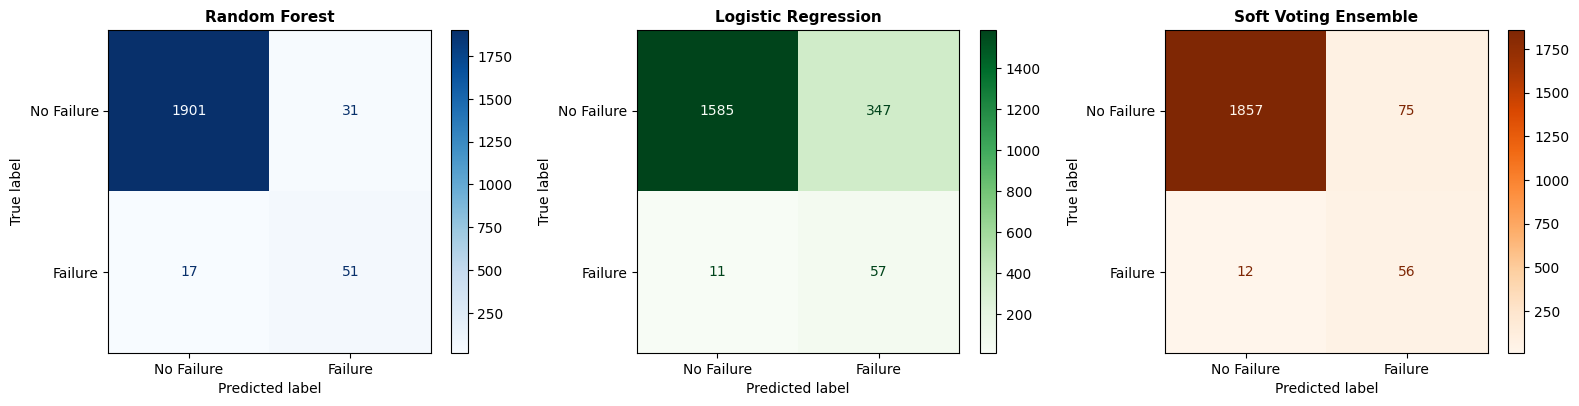


Random Forest:
   TN: 1901, FP: 31, FN: 17, TP: 51
   Specificity: 0.9840
   Sensitivity (Recall): 0.7500

Logistic Regression:
   TN: 1585, FP: 347, FN: 11, TP: 57
   Specificity: 0.8204
   Sensitivity (Recall): 0.8382

Soft Voting Ensemble:
   TN: 1857, FP: 75, FN: 12, TP: 56
   Specificity: 0.9612
   Sensitivity (Recall): 0.8235


In [41]:
print("\n" + "=" * 80)
print("CONFUSION MATRICES (TEST SET)")
print("=" * 80)

rf_cm = confusion_matrix(y_test, rf_test_pred)
lr_cm = confusion_matrix(y_test, lr_test_pred)
voting_cm = confusion_matrix(y_test, voting_test_pred)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

ConfusionMatrixDisplay(rf_cm, display_labels=['No Failure', 'Failure']).plot(
    ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Random Forest', fontsize=11, fontweight='bold')

ConfusionMatrixDisplay(lr_cm, display_labels=['No Failure', 'Failure']).plot(
    ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('Logistic Regression', fontsize=11, fontweight='bold')

ConfusionMatrixDisplay(voting_cm, display_labels=['No Failure', 'Failure']).plot(
    ax=axes[2], cmap='Oranges', values_format='d')
axes[2].set_title('Soft Voting Ensemble', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

for name, cm in [("Random Forest", rf_cm),
                 ("Logistic Regression", lr_cm),
                 ("Soft Voting Ensemble", voting_cm)]:
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{name}:")
    print(f"   TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"   Specificity: {tn / (tn + fp):.4f}")
    print(f"   Sensitivity (Recall): {tp / (tp + fn):.4f}")



ROC CURVE COMPARISON


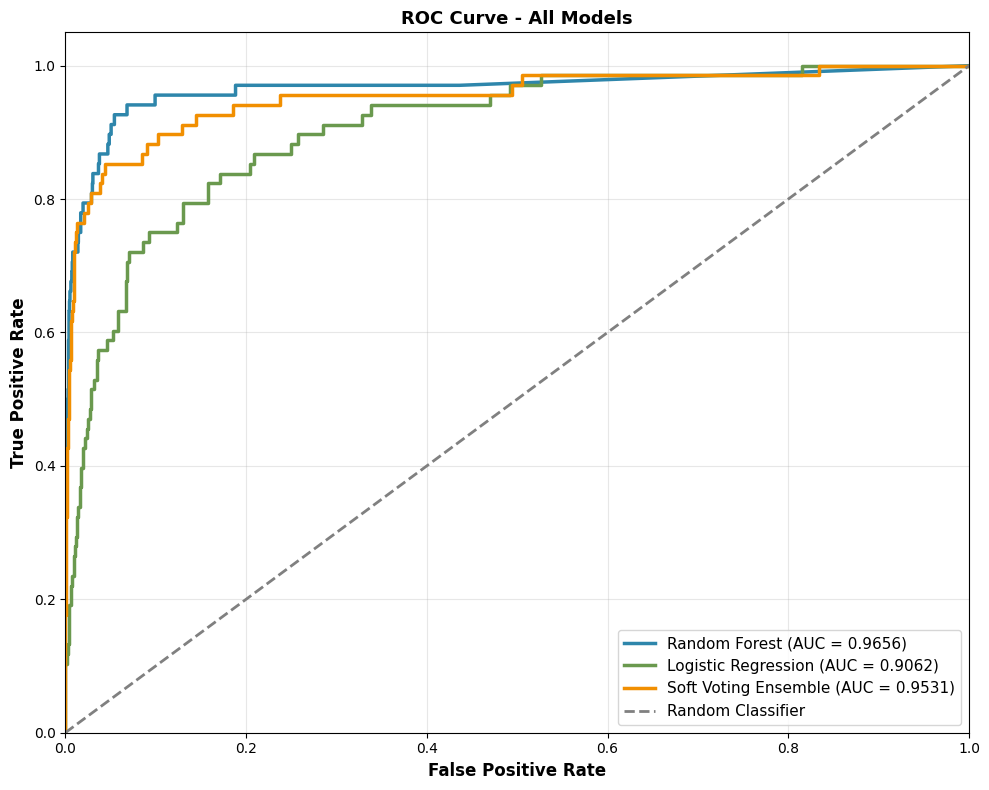

In [43]:
print("\n" + "=" * 80)
print("ROC CURVE COMPARISON")
print("=" * 80)

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_test_proba)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_test_proba)
voting_fpr, voting_tpr, _ = roc_curve(y_test, voting_test_proba)

plt.figure(figsize=(10, 8))
plt.plot(rf_fpr, rf_tpr, lw=2.5,
         label=f'Random Forest (AUC = {rf_roc_auc:.4f})', color='#2E86AB')
plt.plot(lr_fpr, lr_tpr, lw=2.5,
         label=f'Logistic Regression (AUC = {lr_roc_auc:.4f})', color='#6A994E')
plt.plot(voting_fpr, voting_tpr, lw=2.5,
         label=f'Soft Voting Ensemble (AUC = {voting_roc_auc:.4f})', color='#F18F01')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve - All Models', fontsize=13, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



FEATURE IMPORTANCE & COEFFICIENTS

1. Random Forest – Feature Importance:
                Feature  Importance
            Torque [Nm]    0.351448
 Rotational speed [rpm]    0.271283
        Tool wear [min]    0.206869
    Air temperature [K]    0.100398
Process temperature [K]    0.059320
           Type_encoded    0.010683

2. Logistic Regression – Coefficients:
                Feature  Coefficient
            Torque [Nm]     2.408780
    Air temperature [K]     1.759135
 Rotational speed [rpm]     1.722059
Process temperature [K]    -1.205433
        Tool wear [min]     0.867478
           Type_encoded    -0.101799


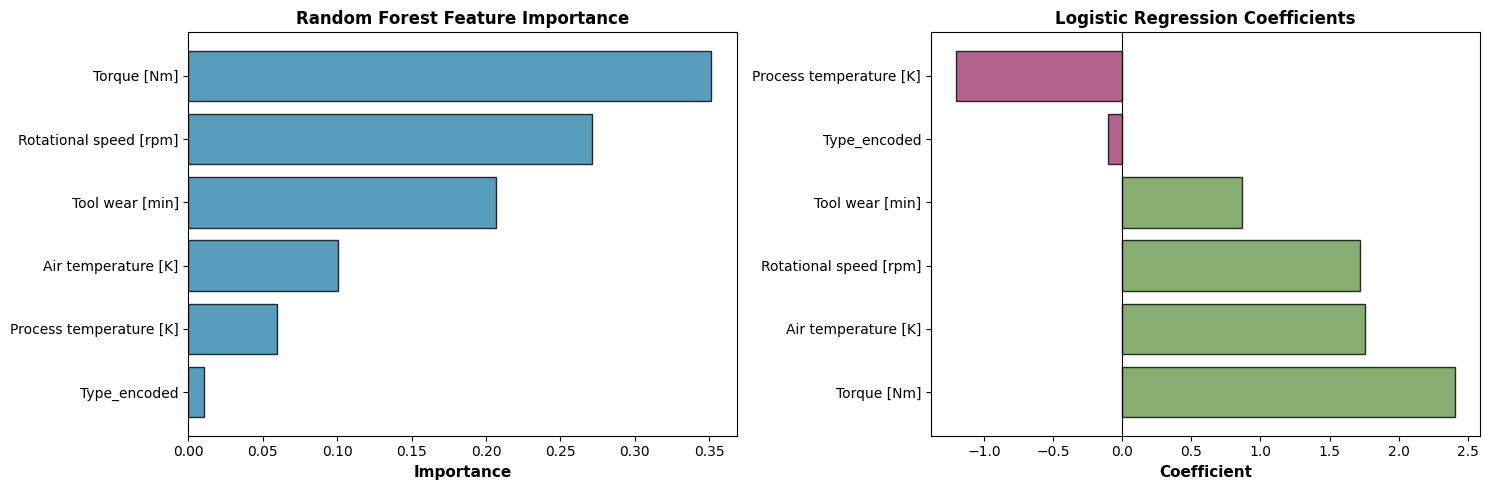

In [45]:
print("\n" + "=" * 80)
print("FEATURE IMPORTANCE & COEFFICIENTS")
print("=" * 80)

print("\n1. Random Forest – Feature Importance:")
rf_feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(rf_feature_importance_df.to_string(index=False))

print("\n2. Logistic Regression – Coefficients:")
lr_coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)
print(lr_coeff_df[['Feature', 'Coefficient']].to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].barh(rf_feature_importance_df['Feature'],
             rf_feature_importance_df['Importance'],
             color='#2E86AB', edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Importance', fontsize=11, fontweight='bold')
axes[0].set_title('Random Forest Feature Importance', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()

lr_sorted = lr_coeff_df.sort_values('Coefficient')
colors = ['#A23B72' if c < 0 else '#6A994E' for c in lr_sorted['Coefficient']]
axes[1].barh(lr_sorted['Feature'], lr_sorted['Coefficient'],
             color=colors, edgecolor='black', alpha=0.8)
axes[1].set_xlabel('Coefficient', fontsize=11, fontweight='bold')
axes[1].set_title('Logistic Regression Coefficients', fontsize=12, fontweight='bold')
axes[1].axvline(0, color='black', linewidth=0.8)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


In [47]:
print("\n" + "=" * 80)
print("EXAMPLE: PREDICTING ON NEW DATA")
print("=" * 80)

new_operations = pd.DataFrame({
    'Air temperature [K]': [298.5, 305.0, 295.0],
    'Process temperature [K]': [309.0, 315.0, 305.0],
    'Rotational speed [rpm]': [2500, 1500, 3500],
    'Torque [Nm]': [45.0, 30.0, 60.0],
    'Tool wear [min]': [150, 50, 250],
    'Type_encoded': [1, 0, 2]
})

print("\nNew Operations:")
print(new_operations)

new_scaled = scaler.transform(new_operations)

rf_pred_new = rf_model.predict(new_scaled)
rf_proba_new = rf_model.predict_proba(new_scaled)[:, 1]

lr_pred_new = lr_model.predict(new_scaled)
lr_proba_new = lr_model.predict_proba(new_scaled)[:, 1]

voting_pred_new = voting_model.predict(new_scaled)
voting_proba_new = voting_model.predict_proba(new_scaled)[:, 1]

print("\nPrediction Summary:")
print(f"{'Op':<4} {'RF':<6} {'RF_Prob':<10} {'LR':<6} {'LR_Prob':<10} {'Ens':<6} {'Ens_Prob':<10}")
print("-" * 60)
for i in range(len(new_operations)):
    print(f"{i+1:<4} {rf_pred_new[i]:<6} {rf_proba_new[i]:<10.4f} "
          f"{lr_pred_new[i]:<6} {lr_proba_new[i]:<10.4f} "
          f"{voting_pred_new[i]:<6} {voting_proba_new[i]:<10.4f}")



EXAMPLE: PREDICTING ON NEW DATA

New Operations:
   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.5                    309.0                    2500   
1                305.0                    315.0                    1500   
2                295.0                    305.0                    3500   

   Torque [Nm]  Tool wear [min]  Type_encoded  
0         45.0              150             1  
1         30.0               50             0  
2         60.0              250             2  

Prediction Summary:
Op   RF     RF_Prob    LR     LR_Prob    Ens    Ens_Prob  
------------------------------------------------------------
1    0      0.2432     1      0.9999     1      0.6215    
2    0      0.1088     0      0.0110     0      0.0599    
3    1      0.5622     1      1.0000     1      0.7811    


In [ ]:
import pickle

print("\n" + "=" * 80)
print("SAVING MODELS AND PREPROCESSORS")
print("=" * 80)

with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("✓ Saved: random_forest_model.pkl")

with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("✓ Saved: logistic_regression_model.pkl")

with open('soft_voting_ensemble.pkl', 'wb') as f:
    pickle.dump(voting_model, f)
print("✓ Saved: soft_voting_ensemble.pkl")

with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Saved: feature_scaler.pkl")

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("✓ Saved: label_encoder.pkl")
